Importando bibliotecas necessárias para o desenvolvimento

In [183]:
import requests
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import openai
from keys import openai_key, nasa_key
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from xgboost import XGBClassifier as XGB
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from imblearn.over_sampling import ADASYN

warnings.simplefilter(action='ignore')

Configurando a Gen AI do OpenAI

In [185]:
openai.api_key = openai_key
headers = {'Authorization': f'Bearer {openai_key}', 'Content-Type': 'application/json'}
link = 'https://api.openai.com/v1/chat/completions'
id_model = 'gpt-4o'

def get_ai_response(prompt):
    body_message = {
        'model': id_model,
        'messages': [{'role': 'user', 'content': prompt}]
    }

    response_ai = requests.post(link, headers=headers, json=body_message)  # Use json= para enviar o corpo como JSON
    return response_ai.json()

Tratando a api e gerando uma lista com os dados que foram selecionados

Criando uma nova função para consumir a api para pegarmos dados do último ano (365 dias), já que o máximo que a api consegue extrair é 7 dias por vez para criarmos modelos melhores precisamos de mais dados

In [186]:
# Chave gerada para acessar a API da Nasa
nasa_key = nasa_key

# Url API Nasa
base_url = 'https://api.nasa.gov/neo/rest/v1/feed'

# Configuração de 365 dias e intervalo de 7 dias
total_days = 365
interval_days = 7

# Lista para armazenar todos os dados de asteroides
year_asteroids = []

# Loop para dividir a solicitação em intervalos de 7 dias
for i in range(0, total_days, interval_days):
    end_date = (datetime.now() - timedelta(days=i)).strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=i + interval_days - 1)).strftime('%Y-%m-%d')
    
    params = {
        'start_date': start_date,
        'end_date': end_date,
        'api_key': nasa_key
    }
    
    # Fazer a requisição
    response = requests.get(base_url, params=params)
    data = response.json()

    # Processar os dados de cada asteroide, adicionando ao year_asteroids
    for date in data['near_earth_objects']:
        for asteroid in data['near_earth_objects'][date]:
            year_asteroids.append({
                'name': asteroid['name'],
                'close_approach_date': asteroid['close_approach_data'][0]['close_approach_date'],
                'miss_distance_km': float(asteroid['close_approach_data'][0]['miss_distance']['kilometers']),
                'relative_velocity_kmh': float(asteroid['close_approach_data'][0]['relative_velocity']['kilometers_per_hour']),
                'is_potentially_hazardous': asteroid['is_potentially_hazardous_asteroid'],
                'absolute_magnitude_h': asteroid['absolute_magnitude_h'],
                'estimated_diameter_min': asteroid['estimated_diameter']['meters']['estimated_diameter_min'],
                'estimated_diameter_max': asteroid['estimated_diameter']['meters']['estimated_diameter_max']
            })



### Explicando as variáveis  
**name**: Nome dado ao asteroide.

**close_approach_date**: Data em que se aproximou da Terra.

**relative_velocity_kmh**: Velocidade do asteroide. Velocidades maiores podem aumentar a energia do impacto, caso ele ocorra.

**estimated_diameter_min** e **estimated_diameter_max**: Intervalo de diâmetro estimado. Asteroides maiores tendem a ter um impacto mais significativo se colidirem com a Terra, o que pode correlacionar com o potencial de risco.

**estimated_diameter_mean**: Média entre diâmetro mínimo e diâmetro máximo estimado.

**miss_distance_km**: Distância mínima entre o asteroide e a Terra durante a passagem. Asteroides com menor distância de aproximação podem ser considerados mais arriscados.

**is_potentially_hazardous**: Diz se é potencialmente perigou ou não.

**absolute_magnitude_h**: Brilho absoluto do asteroide, que pode estar relacionado ao seu tamanho e ao potencial de perigo.

Criando o DataFrame a partir da lista 'asteroids'

In [187]:
df_asteroids = pd.DataFrame(year_asteroids)

Visualizando as primeiras linhas

In [188]:
df_asteroids.head()

,name,close_approach_date,miss_distance_km,relative_velocity_kmh,is_potentially_hazardous,absolute_magnitude_h,estimated_diameter_min,estimated_diameter_max
0,16657 (1993 UB),2024-10-27,5.921104e+07,57205.665720,False,16.55,1301.832102,2910.985075
1,189700 (2001 TA45),2024-10-27,5.685544e+07,21992.037165,False,19.18,387.752830,867.041687
2,(2016 BF1),2024-10-27,3.965309e+06,33240.405089,False,25.40,22.108281,49.435619
3,(2017 HG1),2024-10-27,6.427133e+07,56681.806729,False,27.50,8.405334,18.794898
4,(2018 HA1),2024-10-27,8.580750e+06,87039.972760,False,22.10,101.054342,225.964377


Criando o diametro estimado médio para cada asteroide

In [189]:
df_asteroids['estimated_diameter_mean'] = (df_asteroids['estimated_diameter_max'] + df_asteroids['estimated_diameter_min']) / 2

In [190]:
df_asteroids

,name,close_approach_date,miss_distance_km,relative_velocity_kmh,is_potentially_hazardous,absolute_magnitude_h,estimated_diameter_min,estimated_diameter_max,estimated_diameter_mean
0,16657 (1993 UB),2024-10-27,5.921104e+07,57205.665720,False,16.55,1301.832102,2910.985075,2106.408588
1,189700 (2001 TA45),2024-10-27,5.685544e+07,21992.037165,False,19.18,387.752830,867.041687,627.397259
2,(2016 BF1),2024-10-27,3.965309e+06,33240.405089,False,25.40,22.108281,49.435619,35.771950
3,(2017 HG1),2024-10-27,6.427133e+07,56681.806729,False,27.50,8.405334,18.794898,13.600116
4,(2018 HA1),2024-10-27,8.580750e+06,87039.972760,False,22.10,101.054342,225.964377,163.509359
...,...,...,...,...,...,...,...,...,...
7240,(2023 VW2),2023-10-29,8.611353e+06,37563.121389,False,24.34,36.020935,80.545258,58.283096
7241,(2023 VW3),2023-10-29,1.262504e+07,21142.587711,False,25.29,23.257069,52.004387,37.630728
7242,(2023 VD8),2023-10-29,8.186460e+06,63669.486428,False,23.40,55.533491,124.176661,89.855076
7243,(2023 VE8),2023-10-29,4.719325e+06,29962.335315,False,25.15,24.805899,55.467677,40.136788


Visualizando informações sobre o DataFrame, como o tipo de dado de cada coluna

In [191]:
df_asteroids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7245 entries, 0 to 7244
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      7245 non-null   object 
 1   close_approach_date       7245 non-null   object 
 2   miss_distance_km          7245 non-null   float64
 3   relative_velocity_kmh     7245 non-null   float64
 4   is_potentially_hazardous  7245 non-null   bool   
 5   absolute_magnitude_h      7245 non-null   float64
 6   estimated_diameter_min    7245 non-null   float64
 7   estimated_diameter_max    7245 non-null   float64
 8   estimated_diameter_mean   7245 non-null   float64
dtypes: bool(1), float64(6), object(2)
memory usage: 460.0+ KB


Ajustando o tipo de dados para as colunas necessárias

In [192]:
df_asteroids['close_approach_date'] = pd.to_datetime(df_asteroids['close_approach_date'])

df_asteroids['miss_distance_km'] = df_asteroids['miss_distance_km'].astype('float64')

df_asteroids['relative_velocity_kmh'] = df_asteroids['relative_velocity_kmh'].astype('float64')

Descrição estatítisca dos dados das colunas de data e numéricas

In [193]:
df_asteroids.describe()

,close_approach_date,miss_distance_km,relative_velocity_kmh,absolute_magnitude_h,estimated_diameter_min,estimated_diameter_max,estimated_diameter_mean
count,7245,7.245000e+03,7245.000000,7245.000000,7245.000000,7245.000000,7245.000000
mean,2024-04-25 08:10:32.049689344,3.211548e+07,45771.548065,24.105922,99.769675,223.091774,161.430725
min,2023-10-23 00:00:00,8.098256e+03,1418.218469,9.200000,0.888290,1.986278,1.437284
25%,2024-01-17 00:00:00,9.342494e+06,27567.000550,22.200000,16.016034,35.812940,25.914487
50%,2024-04-20 00:00:00,3.031430e+07,41445.011210,24.390000,35.200998,78.711824,56.956411
75%,2024-08-10 00:00:00,5.238950e+07,60096.963066,26.100000,96.506147,215.794305,156.150226
max,2024-10-27 00:00:00,7.479169e+07,161520.897925,32.380000,38419.789106,85909.260123,62164.524615
std,NaN,2.320236e+07,24265.693099,2.741456,495.056699,1106.980431,801.018565


### Primeira Análise - Número de Asteróides que passaram próximo da Terra
Importante para ver a distribuição de asteroides durante os meses

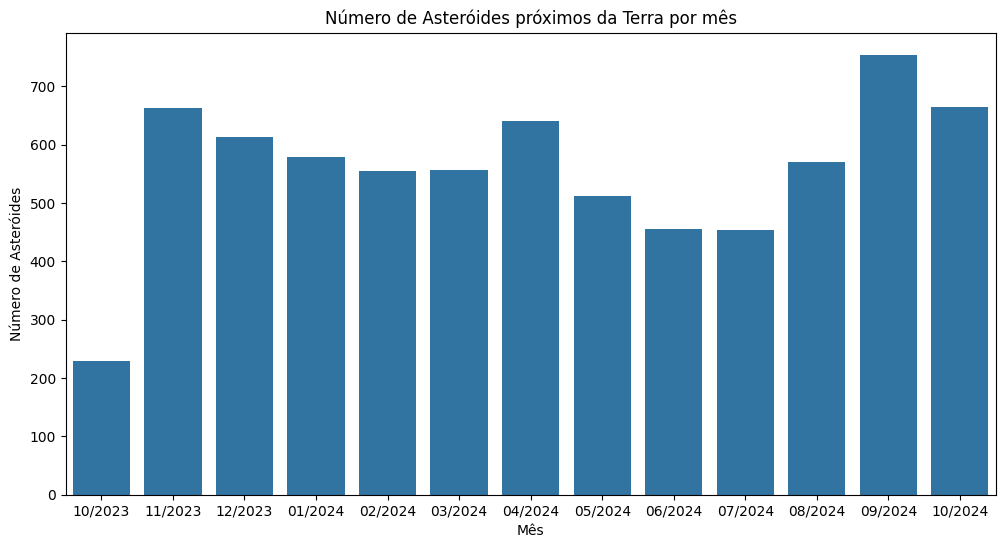

Resposta da IA Generativa:

Os dados apresentam uma variação no número de asteroides próximos da Terra ao longo de um período de um ano. Uma análise sobre esses valores pode indicar algumas tendências e considerações importantes:

1. **Aumento Inicial Significativo**: Nota-se um aumento considerável de asteroides de outubro de 2023 (230) para novembro de 2023 (662). Isso pode indicar um evento ou condições astronômicas específicas que resultaram em um maior número de asteroides próximos da Terra durante esse mês.

2. **Flutuações ao Longo do Tempo**: Após o pico em novembro, o número de asteroides diminui gradualmente até julho de 2024 (453), com algumas flutuações ao longo dos meses. Esta variação pode sugerir mudanças nas condições espaciais ou melhorias nas tecnologias de detecção, influenciando a contagem dos asteroides.

3. **Outro Pico em Setembro de 2024**: Há outro aumento acentuado em setembro de 2024 (754), sugerindo novamente um possível evento ou fenômeno que leva a um aume

In [201]:
# Converter para períodos mensais
asteroids_per_month = df_asteroids['close_approach_date'].dt.to_period('M').value_counts().sort_index()

# Converter o índice para o formato 'Ano-Mês'
asteroids_per_month.index = asteroids_per_month.index.strftime('%m/%Y')

plt.figure(figsize=(12,6))
sns.barplot(x=asteroids_per_month.index, y=asteroids_per_month.values)
plt.title('Número de Asteróides próximos da Terra por mês')
plt.xlabel('Mês')
plt.ylabel('Número de Asteróides')
plt.show()

prompt = f"Os dados a seguir mostram o número de asteroides próximos da Terra por dia: {asteroids_per_month.to_dict()}. Comente sobre o que esses dados podem indicar sobre a atividade de asteroides."
response_ai = get_ai_response(prompt)

print('Resposta da IA Generativa:\n')
print(response_ai['choices'][0]['message']['content'])

### Segunda Análise - Média de distância mínima da Terra por mês

Importante para poder visualizar possíveis momentos do ano que tivemos uma menor distância média dos asteroides da Terra

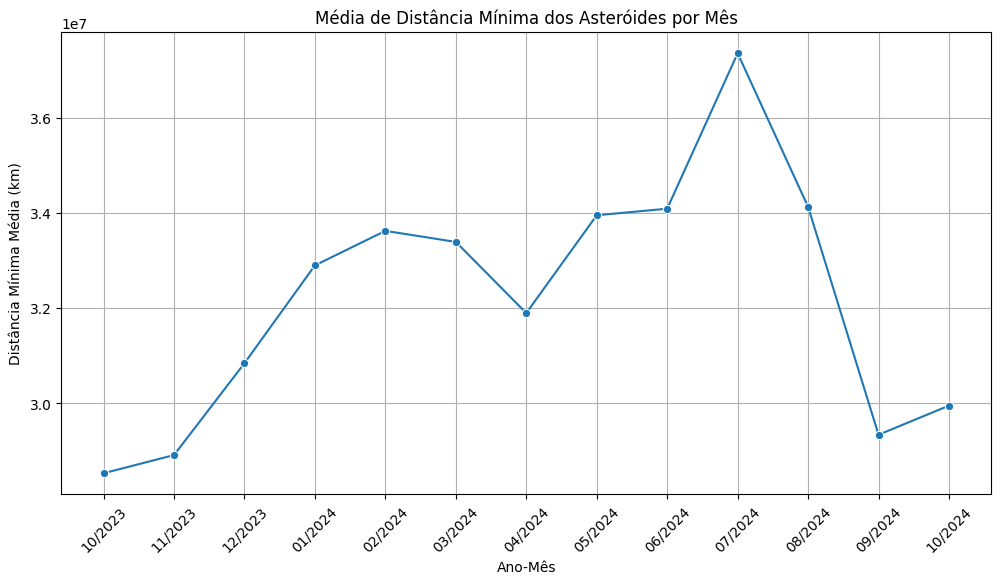

In [217]:
# criando uma nova coluna com mês-ano
df_asteroids['year_month'] = df_asteroids['close_approach_date'].dt.to_period('M')

# criando uma média de distância mínima agrupado por mês-ano
mean_distance_per_month = df_asteroids.groupby('year_month')['miss_distance_km'].mean().reset_index()

# Alterando a string da data
mean_distance_per_month['year_month'] = mean_distance_per_month['year_month'].dt.strftime('%m/%Y')

plt.figure(figsize=(12, 6))
sns.lineplot(data=mean_distance_per_month, x='year_month', y='miss_distance_km', marker='o')
plt.title('Média de Distância Mínima dos Asteróides por Mês')
plt.xlabel('Ano-Mês')
plt.ylabel('Distância Mínima Média (km)')
plt.xticks(rotation=45)  
plt.grid()
plt.show()

### Terceira Análise - Proporção de ateroides perigosos/não perigosos á Terra
Importante para ver a proporção de asteroides que trazem algum perigo à Terra, para as entidades possam tomar algum tipo de prevenção contra os perigosos

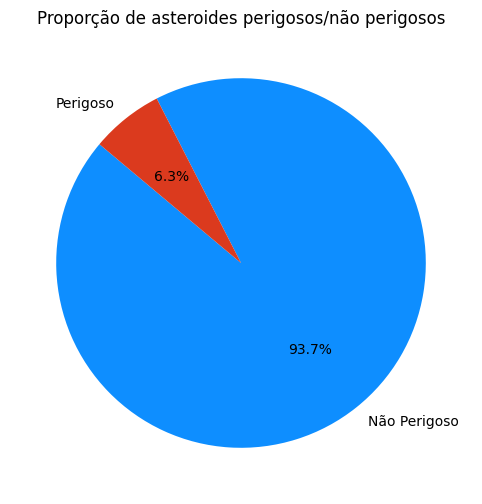

Resposta da IA Generativa:

Os dados fornecidos indicam a classificação de 7.245 asteroides quanto à sua periculosidade, sendo que 6785 são considerados não perigosos e 460 são considerados perigosos. Isso sugere que a grande maioria dos asteroides observados não representa uma ameaça significativa à Terra, representando cerca de 93,65% do total. Apenas 6,35% são classificados como perigosos, o que, apesar de ser uma proporção relativamente pequena, ainda é uma quantidade significativa em termos absolutos, especialmente considerando o potencial de danos catastróficos associados a eventuais impactos de asteroides.

Essa classificação é provavelmente baseada em critérios como o tamanho do asteroide, sua trajetória orbital e a proximidade esperada de sua passagem pela Terra. Asteroides potencialmente perigosos são aqueles que têm o potencial de chegar suficientemente perto da Terra e são grandes o bastante para causar danos substanciais em caso de impacto.

Este tipo de análise é crucial 

In [202]:
plt.figure(figsize=(12, 6))
hazardous_count = df_asteroids['is_potentially_hazardous'].value_counts()
plt.pie(hazardous_count, labels=['Não Perigoso', 'Perigoso'], autopct='%1.1f%%', startangle=140, colors=['#0E8EFF', '#DB3A1E'])
plt.title('Proporção de asteroides perigosos/não perigosos')
plt.show()

prompt = f"Os dados a seguir mostram a proporção de asteroides perigosos e não perigosos: {hazardous_count.to_dict()}. Comente sobre."
response_ai = get_ai_response(prompt)

print('Resposta da IA Generativa:\n')
print(response_ai['choices'][0]['message']['content'])

A partir de agora a amostragem utilizada foi semanal para facilitar a análise e podermos utilizar a IA Genrativa para complementar a análise nesses casos

In [ ]:
# Calcular a data limite para os últimos 7 dias
last_week = datetime.now() - timedelta(days=7)

# Filtrar o DataFrame para incluir apenas os asteroides dos últimos 7 dias
df_last_7_days = df_asteroids[df_asteroids['close_approach_date'] >= last_week]

### quarta Análise - Visualizando correlação entre Menor distância e diâmetro máximo estimado
Importante para visualizar qual é o diâmetro dos asteroides que passam mais perto da Terra
Assim, temos uma noção de quanto estrago o asteroide poderia gerar se chegasse até a Terra
- Nesse caso há um certo padrão nessa distribuição, os asteroides estão mais agrupados no canto inferior esquerdo,  
denotando que os asteroides que chegam mais próximos à Terra geralmente são menores

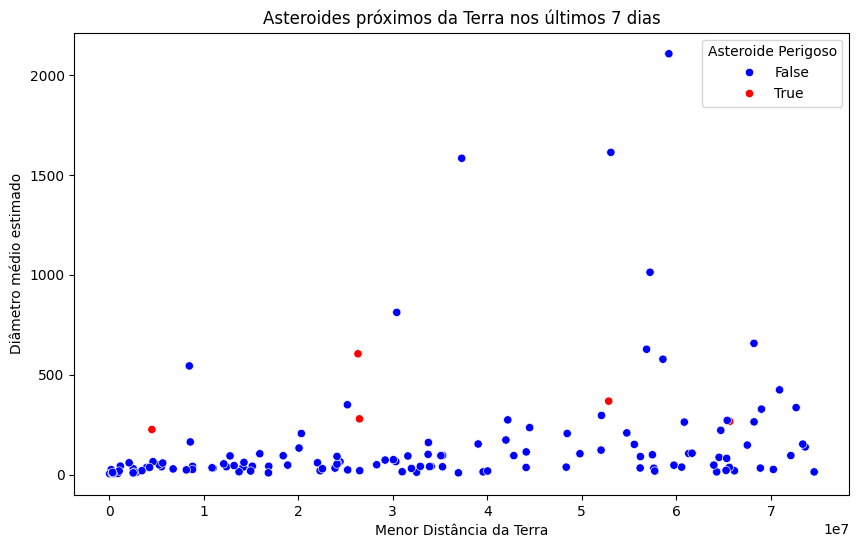

Resposta da IA Generativa:

A análise dos dados fornecidos sobre asteroides envolve dois conjuntos de informações: os diâmetros médios estimados dos asteroides e as suas mínimas distâncias da Terra.

1. **Diâmetro Médio Estimado:**
   - Os valores de diâmetros médios variam significativamente, de cerca de 4,42 até 2106 unidades (presumivelmente quilômetros). Isso indica uma grande diversidade no tamanho dos asteroides observados.
   - O maior diâmetro estimado é 2106.41, o que poderia representar um grande corpo celeste comparado a outros asteroides menores no conjunto de dados.

2. **Mínima Distância da Terra:**
   - As mínimas distâncias dos asteroides à Terra variam de cerca de 363 mil até mais de 73 milhões de unidades (presumivelmente quilômetros). Essa variação reflete a proximidade ou afastamento dos asteroides em suas órbitas em relação à Terra.
   - Vale notar que mesmo as menores distâncias estão em uma ordem de grandeza que sugere que estes asteroides, mesmo os que passam "p

In [205]:
# Plotar o gráfico de dispersão apenas para os últimos 7 dias
plt.figure(figsize=(10, 6))
sns.scatterplot(x='miss_distance_km', y='estimated_diameter_mean', hue='is_potentially_hazardous', 
                data=df_last_7_days, palette={True: 'red', False: 'blue'})
plt.xlabel('Menor Distância da Terra')
plt.ylabel('Diâmetro médio estimado')
plt.legend(title='Asteroide Perigoso')
plt.title('Asteroides próximos da Terra nos últimos 7 dias')
plt.show()

prompt = f"""
O que você pode comentar sobre {df_last_7_days['estimated_diameter_mean'].to_dict()} e {df_last_7_days['miss_distance_km'].to_dict()} dado que sao valores de diametros medios estimados de um asteroide e a minima distancia de um asteroiude da Terra, respectivamente.
"""

response_ai = get_ai_response(prompt)

print('Resposta da IA Generativa:\n')
print(response_ai['choices'][0]['message']['content'])

### Quinta Análise - Visualizando a distribuição de diametro médio dos asteroides
Importante para observarmos o tamanho dos asteroides que passam perto da Terra, pois assim podemos ter uma noção de estrago que poderiam causar.

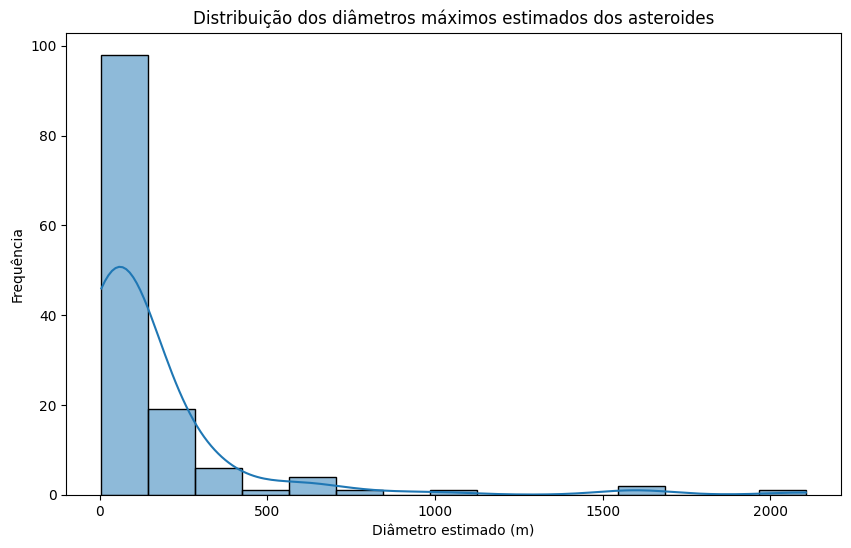

Resposta da IA Generativa:

Para comentar sobre a média das estimativas dos asteroides e sua distribuição, começamos calculando a média aritmética. A lista de estimativas parece conter posições identificadas numericamente seguidas por suas respectivas valorizações. Para calcular a média, somamos todas as estimativas e dividimos pelo número total de entradas.

Após somar todas as estimativas apresentadas, o resultado é aproximadamente 15,765.541. Dividindo esse total pelo número de entradas (133), obtemos uma média de aproximadamente 118.52.

Sobre a distribuição dessas estimativas:

1. **Amplitude e Variabilidade**: A estimativa mínima é 4.41918941695, enquanto a máxima é 2,106.4085884897, indicando uma ampla gama de valores. Isso sugere que enquanto alguns asteroides têm estimativas de tamanho relativamente pequenas, outros têm estimativas consideravelmente maiores.

2. **Distribuição Direcionada à Direita (Right Skewed)**: A presença de valores muito altos (outliers) indica que a dis

In [207]:
plt.figure(figsize=(10, 6))
sns.histplot(df_last_7_days['estimated_diameter_mean'], kde=True, bins=15)
plt.title('Distribuição dos diâmetros máximos estimados dos asteroides')
plt.xlabel('Diâmetro estimado (m)')
plt.ylabel('Frequência')
plt.show()

prompt = f"""
O que você pode comentar sobre a média das etimativas dos asteroides: {df_last_7_days['estimated_diameter_mean'].to_dict()}. Comente sobre sua distribuição.
"""

response_ai = get_ai_response(prompt)

print('Resposta da IA Generativa:\n')
print(response_ai['choices'][0]['message']['content'])

### Sexta Análise - Vendo a distribuição das velocidades
Visualizando a distribuição de velocidade dos asteroides

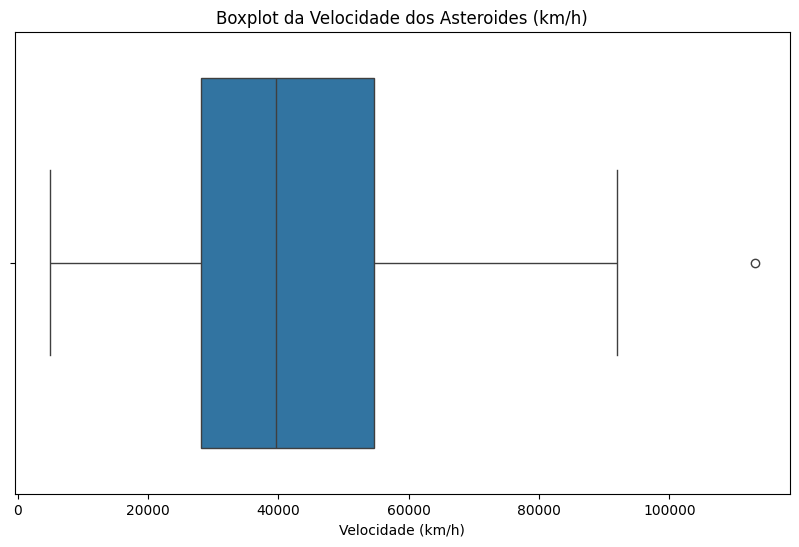

Resposta da IA Generativa:

As velocidades dos asteroides listadas variam de um mínimo de 4.966 km/h (asteroide 50) a um máximo de 113.072 km/h (asteroide 115). Isso mostra uma ampla gama de velocidades, o que não é incomum para asteroides, pois eles podem ter órbitas e composições bastante diferentes, afetando suas velocidades. 

Alguns pontos a considerar:

1. **Distribuição de Velocidades**: A maioria das velocidades parece estar concentrada entre 20.000 km/h e 60.000 km/h, o que é consistente com a velocidade média de muitos asteroides conhecidos no cinturão de asteroides entre Marte e Júpiter.

2. **Asteroides mais rápidos**: Asteroides como os números 115 (113.072 km/h) e 5 (91.900 km/h) são significativamente mais rápidos do que a média. Isso pode indicar uma trajetória altamente elíptica ou uma interação recente com outros corpos celestes, que os acelerou.

3. **Asteroides mais lentos**: Asteroides como os números 50 (4.967 km/h) e 126 (7.980 km/h) são mais lentos e podem estar

In [210]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='relative_velocity_kmh', data=df_last_7_days)
plt.title('Boxplot da Velocidade dos Asteroides (km/h)')
plt.xlabel('Velocidade (km/h)')
plt.show()


prompt = f"""
O que você pode comentar sobre a velocidade dos asteroides: {df_last_7_days['relative_velocity_kmh'].to_dict()}.
"""

response_ai = get_ai_response(prompt)

print('Resposta da IA Generativa:\n')
print(response_ai['choices'][0]['message']['content'])

## Machine Learning

### Tentativa de Predição se o asteroide é perigoso ou não

Definição da função para retornar as métricas

In [176]:
def scores(y_true, y_pred, features, sampling, model, sampling_method):

    if sampling_method == 'undersampling':
        sampling_method = f'US - {sampling}'  # Descreve a taxa de balanceamento
    elif sampling_method == 'oversampling':
        sampling_method = f'ADASYN - {sampling}'  # Método de amostragem ADASYN
    else:
        sampling_method = 'class_weight'
        
    return {
        "Features": features,
        "Algoritmo": str(model),
        "Acurácia": round(accuracy_score(y_true, y_pred),3),
        "Precisão": round(precision_score(y_true, y_pred, zero_division=0), 3),
        "Recall": round(recall_score(y_true, y_pred, zero_division=0), 3),
        "F1-Score": round(f1_score(y_true, y_pred),3),
        "AUC-ROC": round(roc_auc_score(y_true, y_pred),3),
        "Método": str(sampling_method)
    }

Variáveis para inputar nos modelos

In [177]:
sampling = [0.5, 0.6, 0.7]
sampling_method = ['undersampling', 'oversampling', 'class_weight']
model = [DT(random_state=0), RF(random_state=0), LR(random_state=0, max_iter=200), XGB(random_state=0)]

features = ['feat1', ['relative_velocity_kmh', 'estimated_diameter_min', 'estimated_diameter_max', 'estimated_diameter_mean', 'miss_distance_km', 'absolute_magnitude_h']]

products = []
for method in sampling_method:
    for samp in (sampling if method != 'class_weight' else [1]):
            for mod in model:
                    products.append({
                        'sampling_method': method,
                        'sampling': samp,
                        'model': mod,
                        'feature': features
                    })

Todas as combinações de variáveis  
Gerando um total de 27 modelos preditivos

In [178]:
pd.DataFrame(products)

,sampling_method,sampling,model,feature
0,undersampling,0.5,DecisionTreeClassifier(random_state=0),"[feat1, [relative_velocity_kmh, estimated_diam..."
1,undersampling,0.5,RandomForestClassifier(random_state=0),"[feat1, [relative_velocity_kmh, estimated_diam..."
2,undersampling,0.5,"LogisticRegression(max_iter=200, random_state=0)","[feat1, [relative_velocity_kmh, estimated_diam..."
3,undersampling,0.5,"XGBClassifier(base_score=None, booster=None, c...","[feat1, [relative_velocity_kmh, estimated_diam..."
4,undersampling,0.6,DecisionTreeClassifier(random_state=0),"[feat1, [relative_velocity_kmh, estimated_diam..."
5,undersampling,0.6,RandomForestClassifier(random_state=0),"[feat1, [relative_velocity_kmh, estimated_diam..."
6,undersampling,0.6,"LogisticRegression(max_iter=200, random_state=0)","[feat1, [relative_velocity_kmh, estimated_diam..."
7,undersampling,0.6,"XGBClassifier(base_score=None, booster=None, c...","[feat1, [relative_velocity_kmh, estimated_diam..."
8,undersampling,0.7,DecisionTreeClassifier(random_state=0),"[feat1, [relative_velocity_kmh, estimated_diam..."
9,undersampling,0.7,RandomForestClassifier(random_state=0),"[feat1, [relative_velocity_kmh, estimated_diam..."


Função principal para a criação dos modelos preditivos e testes   
Função baseada no RMMS[Giusti et al. 2022] (REGRESSIVE MULTI-DIMENSIONAL MODEL SELECTION)

In [179]:
def classification_predictions(df, features, model, sampling=None, sampling_method=None, return_model=False):

    X = df[features[1]]
    y = df['is_potentially_hazardous']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    if sampling_method == "undersampling":
        y_train = pd.concat([y_train[y_train==1], y_train[y_train==0].sample(int((len(y_train[y_train == 1]) * sampling)/(1 - sampling)), random_state=0)])
        X_train = X_train.loc[y_train.index]
    elif sampling_method == "oversampling":
        ada = ADASYN(sampling_strategy=sampling, random_state=0)
        X_train, y_train = ada.fit_resample(X_train, y_train)
    elif sampling_method == "class_weight":
        model.set_params(class_weight='balanced')

    # Treinamento do modelo
    model.fit(X_train, y_train)

    # Predições após o treinamento
    y_pred = model.predict(X_test)

    if return_model:
        return model, y_pred, X_test, y_test, df
    else:
        # Métricas avaliativas comparando o conjunto de teste e o conjunto previsto
        result = scores(y_test, y_pred, features[0], sampling, model, sampling_method=sampling_method)   
        return result

Chamada da função principal e armazenamento dos resultados

In [180]:
results = []
for product in products:
                results.append(classification_predictions(
                    df_asteroids, 
                    features=product['feature'], 
                    model=product['model'], 
                    sampling=product['sampling'], 
                    sampling_method=product['sampling_method'], 
                ))

Observando os resultados e ordenando pelo F1-Score

In [181]:
df_results = pd.DataFrame(results)
df_results.sort_values('F1-Score', ascending=False).reset_index(drop=True)

,Features,Algoritmo,Acurácia,Precisão,Recall,F1-Score,AUC-ROC,Método
0,feat1,DecisionTreeClassifier(random_state=0),0.908,0.373,0.652,0.474,0.789,ADASYN - 0.6
1,feat1,"XGBClassifier(base_score=None, booster=None, c...",0.908,0.371,0.641,0.470,0.784,ADASYN - 0.7
2,feat1,RandomForestClassifier(random_state=0),0.905,0.363,0.663,0.469,0.792,ADASYN - 0.7
3,feat1,DecisionTreeClassifier(class_weight='balanced'...,0.934,0.482,0.446,0.463,0.707,class_weight
4,feat1,RandomForestClassifier(random_state=0),0.910,0.371,0.609,0.461,0.769,ADASYN - 0.5
5,feat1,RandomForestClassifier(random_state=0),0.903,0.355,0.641,0.457,0.781,ADASYN - 0.6
6,feat1,"XGBClassifier(base_score=None, booster=None, c...",0.906,0.359,0.609,0.452,0.768,ADASYN - 0.5
7,feat1,RandomForestClassifier(random_state=0),0.870,0.305,0.815,0.444,0.845,US - 0.7
8,feat1,RandomForestClassifier(random_state=0),0.854,0.289,0.891,0.436,0.871,US - 0.6
9,feat1,DecisionTreeClassifier(random_state=0),0.905,0.349,0.576,0.434,0.752,ADASYN - 0.7
